<a href="https://colab.research.google.com/github/janpeter19/BPL_IEC_operation/blob/main/BPL_IEC_operation_fmpy_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BPL_IEC_operation script with FMPy

The key library FMPy is installed.

After the installation a small application BPL_IEC_operation is loaded and run. You can continue with this example if you like.

In [1]:
!lsb_release -a # Actual VM Ubuntu version used by Google

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.4 LTS
Release:	22.04
Codename:	jammy


In [2]:
!python --version

Python 3.11.11


In [3]:
!pip install fmpy==0.3.20


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 5.6 MB/s eta 0:00:00


Now specific installation and the run simulations. Start with connecting to Github. Then upload the two files:

* FMU - BPL_IEC_operation_linux_om_me.fmu
* Setup-file - BPL_IEC_operation_fmpy_explore.py

In [4]:
%%bash
git clone https://github.com/janpeter19/BPL_IEC_operation

Cloning into 'BPL_IEC_operation'...


In [5]:
%cd BPL_IEC_operation

/content/BPL_IEC_operation


# BPL_IEC_operation

Authors: Karl Johan Brink and Jan Peter Axelsson

In this notebook we show operation of a typical ion-exchange chromatography step.
The impact of pH is also illustrated.

The model is based on the simplified model [1].

In [6]:
run -i BPL_IEC_fmpy_explore.py

Linux - run FMU pre-compiled OpenModelica

Model for bioreactor has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values/units

Note that both disp() and describe() takes values from the last simulation
and the command process_diagram() brings up the main configuration

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


In [7]:
plt.rcParams['figure.figsize'] = [30/2.54, 24/2.54]

No processDiagram.png file in the FMU, but try the file on disk.


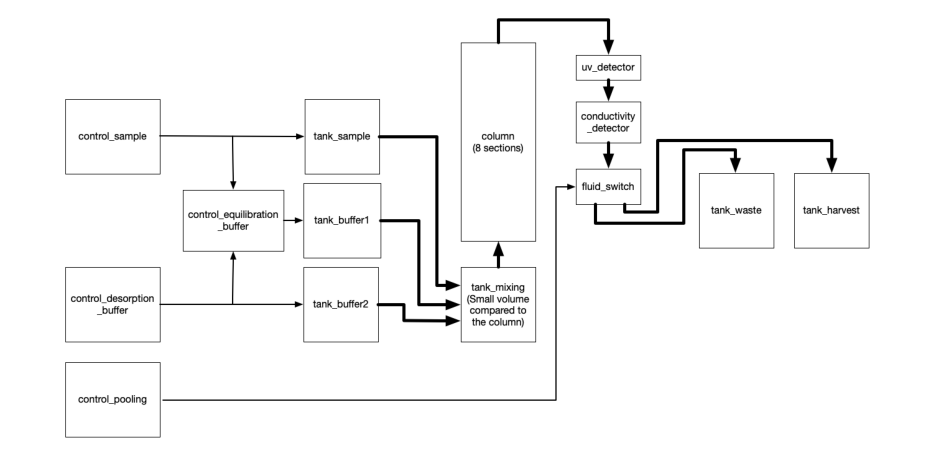

In [9]:
# The process diagram is made outside Modelica to illustrate the configuration
process_diagram()

## 1 Typical parameters an ion exchange chromatography column step

In [10]:
# From  given colunn height (h) diameter (d) and linear flow rate (lfr)
# actual column volume (V) and volume flow rate (VFR) are calculated below.

from numpy import pi
h = 20.0
d = 1.261
a = pi*(d/2)**2
V = h*a
print('V =', np.round(V,1), '[mL]')

lfr = 48
VFR = a*lfr/60
print('VFR =', np.round(VFR,1), '[mL/min]')

V = 25.0 [mL]
VFR = 1.0 [mL/min]


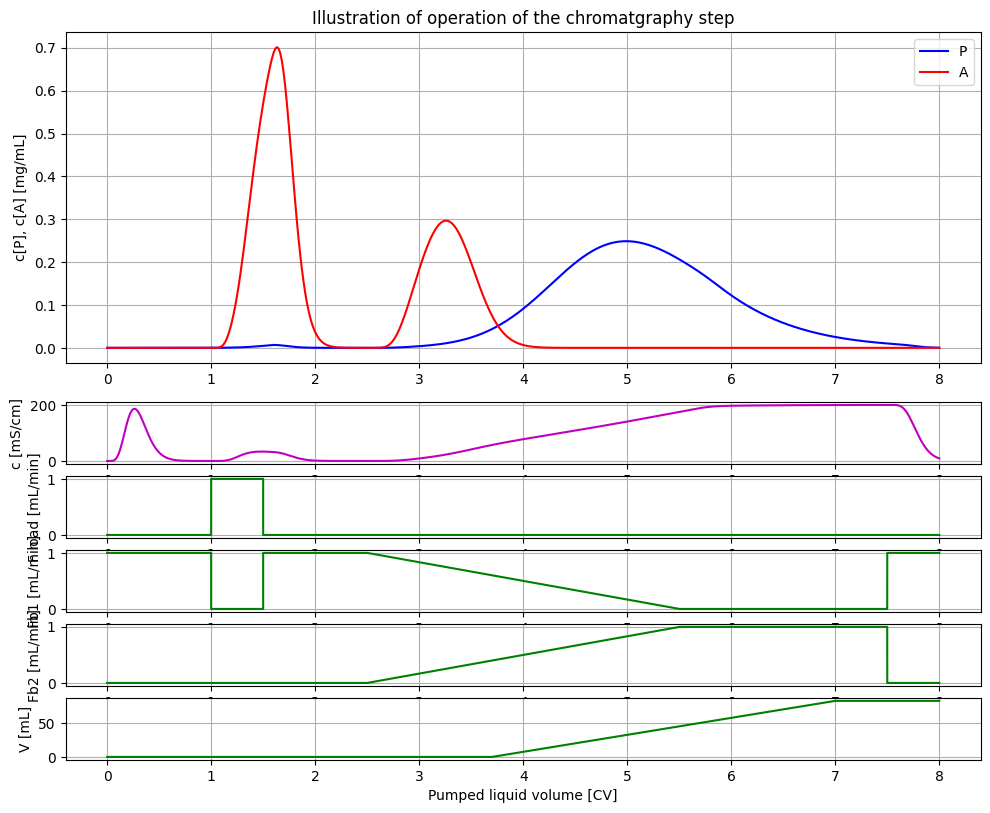

In [11]:
# Sample concentration product P_in and antagonist A_in
par(P_in = 1.0)
par(A_in = 1.0)
par(E_in = 0.0)

# Column properties are described by the size and binding capacity of the resin Q_av
par(height = h)
par(diameter = d)
par(Q_av = 6.0)

# Resin parameters - default values used

# Remaining salt koncentration in the column from prvious batch and eliminated during the initial equilibration period
init(E_start = 50)

# Salt concentration of the desorption buffer
par(E_in_desorption_buffer = 8.0)

# Flow rate rate through the
par(LFR=lfr)

# Switching points during operation are conveniently described in terms of multiples of the column volume V
CV_ekv = 1.0
CV_ads = 0.5
CV_wash = 1.0
CV_desorb = 3.0
CV_start_pool = 1.2
CV_stop_pool = 4.5
CV_wash2 = 2.5
par(scale_volume=True, start_adsorption=CV_ekv*V, stop_adsorption=(CV_ekv+CV_ads)*V)
par(start_desorption=(CV_ekv+CV_ads+CV_wash)*V, stationary_desorption=(CV_ekv+CV_ads+CV_wash+CV_desorb)*V)
par(stop_desorption=7.5*V)
par(start_pooling=(CV_ekv+CV_ads+CV_wash+CV_start_pool)*V, stop_pooling=(CV_ekv+CV_ads+CV_wash+CV_stop_pool)*V)

# Simulation and plot of results
newplot(title='Illustration of operation of the chromatgraphy step', plotType='Elution-conductivity-vs-CV-combined-all')
simu((CV_ekv+CV_ads+CV_wash+CV_desorb+CV_wash2)*V/VFR)

Comments of steps of operations:
1) Time: 0-1 hours - equilibration. Just to illustrate the equilibration process the first part of the column is given an initial value of salt concentration.
2) Time: 1-1.5 hours - sample is loaded on the column. The product P is adsorbed to the columne and just a small amount passes through and goes to the waste. The antagonist A is much less adsrobed.
3) Time: 1.5-2.5 hours - washing 1. The column comes to equilibrium and both antagonist and product comes down to low levels.
4) Time: 2.5-5.5 hours - desorption. A linear gradient of increaseing salt concentration is applied. First the antagonist and later the product comes out.
5) Time: 5.5-7.5 hours - washing 2 The The column has constant salt concentration and stationary desorption.
6) Time: 3.7-7.0 hours - pooling of product. The start- and stop of pooling are chosen with trade-off between maximizing the product pooled and minimize the amount of antagonist in the pooling.
7) Time: 7.5-8.0 hours - desorption stopped and salt is washed out and preparation of the next batch to come.

Note that step 4 and 5 is parallel to step 6.

In [12]:
# Check mass-balance of P and A
P_mass = model_get('tank_harvest.m[1]') + model_get('tank_waste.m[1]')
A_mass = model_get('tank_harvest.m[2]') + model_get('tank_waste.m[2]')
print('P_mass [mg] =', P_mass)
print('A_mass [mg] =', A_mass)

P_mass [mg] = 12.422130344957237
A_mass [mg] = 12.488781164503445


## 2 The impact of the slope of the desorption gradient

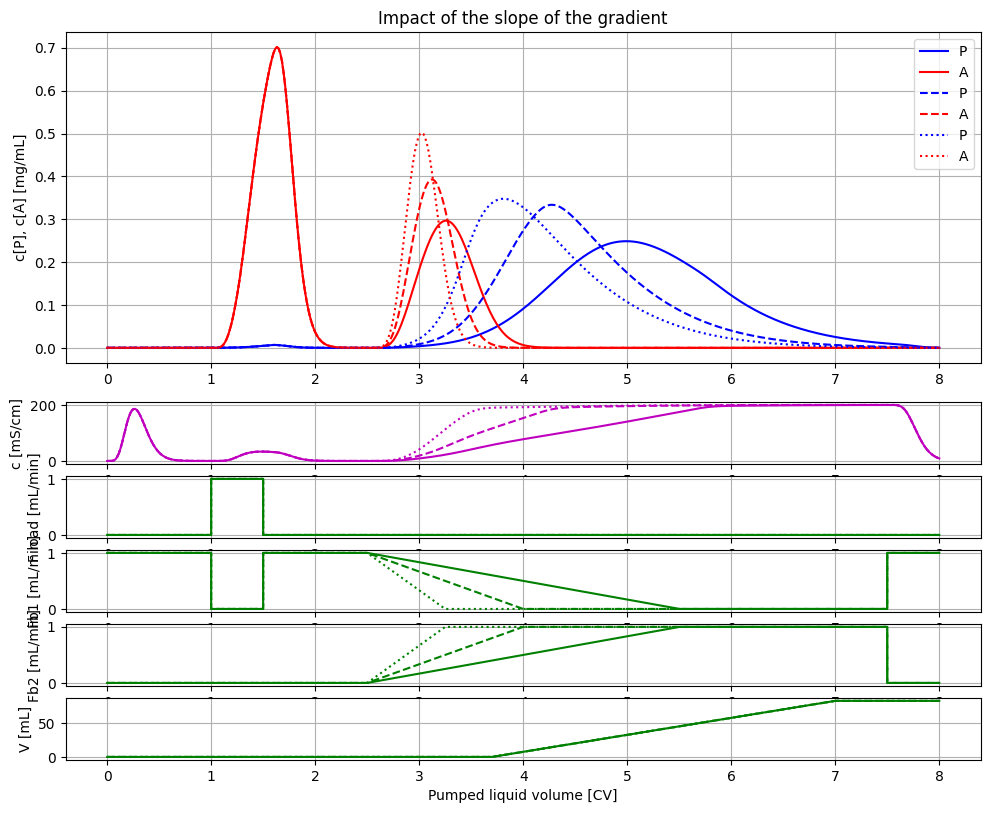

In [13]:
# Simulations showing the impact of change of slope of the desorption gradient
newplot(title='Impact of the slope of the gradient', plotType='Elution-conductivity-vs-CV-combined-all')

# Same gradienet as before
par(start_desorption=(CV_ekv+CV_ads+CV_wash)*V, stationary_desorption=(CV_ekv+ CV_ads+CV_wash+CV_desorb)*V)
par(stop_desorption=7.5*V)
simu((CV_ekv+CV_ads+CV_wash+CV_desorb+CV_wash2)*V/VFR)

# Gradeint finishes after 0.5 of the volume
par(stationary_desorption = (CV_ekv + CV_ads + CV_wash + 0.5*CV_desorb)*V )
simu((CV_ekv+CV_ads+CV_wash+CV_desorb+CV_wash2)*V/VFR)

# Fradient finishes after 0.25 of the volume
par(stationary_desorption = (CV_ekv + CV_ads + CV_wash + 0.25*CV_desorb)*V )
simu((CV_ekv+CV_ads+CV_wash+CV_desorb+CV_wash2)*V/VFR)

## 3 The impact of salt concentration in the sample

These values should be compared with the expected value 12.5 mg, i.e. half a column volume with sample concentration 1 mg/L. The difference is due to numerical errors during simulation.

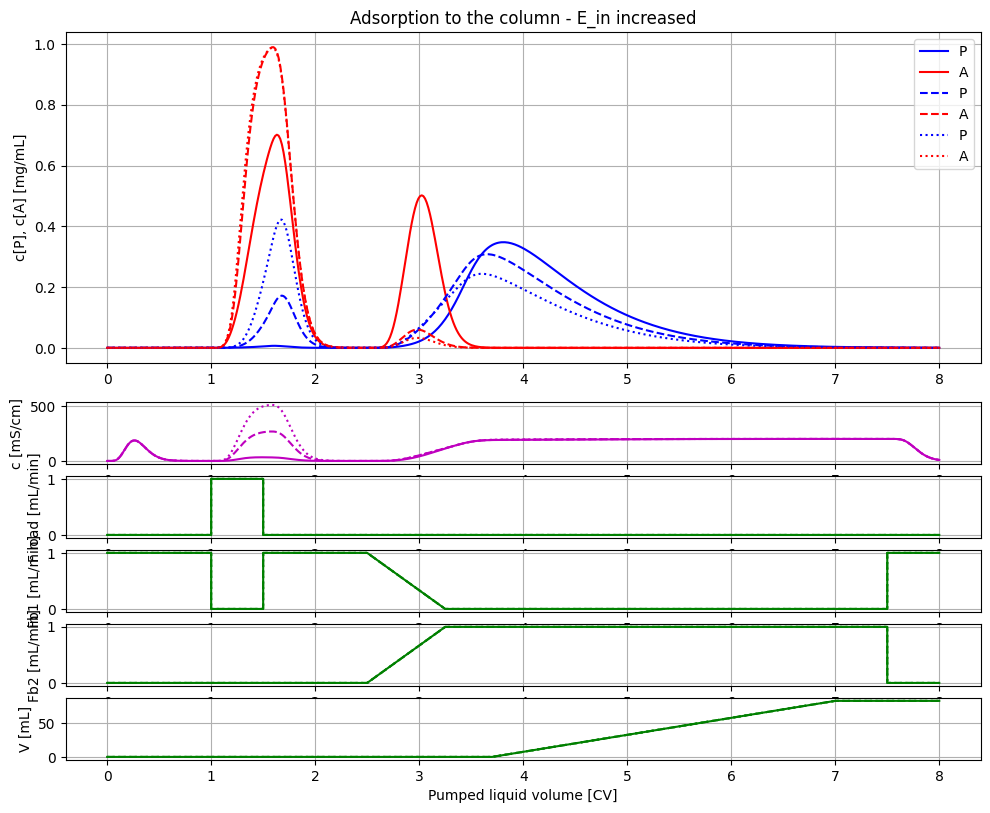

In [14]:
# Let us investigate the impact of increasing salt concetration in the sample E_in

# Simulate and plot the results
newplot(title='Adsorption to the column - E_in increased', plotType='Elution-conductivity-vs-CV-combined-all')

for value in [0, 10, 20]:
    par(E_in=value)
    simu((CV_ekv+CV_ads+CV_wash+CV_desorb+CV_wash2)*V/VFR)

# Restore default values
par(k2=0.05, k4=0.3, E_in=0)

Note, that increased salt concentration in the sample affect binding of both proteins.  During adsorption less  is bound. During desoprtion less product P can be harvested but the fraction of antagonist A may be lowered.
Thus, some product is lost but the quality in terms of purity is improved.

## 4 The impact of change of binding strength due to pH
There are many factors that contribute to the binding strength. A most important factor is the pH-value of the resin and the characteristic iso-electric point of the protein. The binding strenght can be seen as proportional to the difference.

The binding strength of the resin is described by the quotient KP=k1/k2 for the protein P and similarly KA=k3/k4 for the protein A.

Below a few help-functions that describe this idea of the pH difference and its impact on binding strength in terms of the parameters k1, k2, k3, and k4 of the protein-resin interaction.

In [15]:
# Define function that describe the proportionality of binding strength ot
# the pH difference of the iso-electric point and the resin

def KP_pH_sensitivity(pI_P=8.0, pH_resin=7.0):
    K_P_nom = 0.0
    coeff_pH = 6.0
    return K_P_nom + coeff_pH*(pI_P-pH_resin)

def KA_pH_sensitivity(pI_A=7.1667, pH_resin=7.0):
    K_A_nom = 0.0
    coeff_pH = 1.0
    return K_A_nom + coeff_pH*(pI_A-pH_resin)

def par_pH(pI_P=8.0, pI_A=7.1667, pH_resin=7.0, TP=3.33, TA=20.0):
    if (pI_P > pH_resin) & (pI_A > pH_resin):
        par(k2 = 1/(TP*KP_pH_sensitivity(pI_P=pI_P, pH_resin=pH_resin)))
        par(k4 = 1/(TA*KA_pH_sensitivity(pI_A=pI_A, pH_resin=pH_resin)))
    else:
        print('Both pI_P > pH_resin and pI_A > pH_resin must hold - no parameter change made')

In [16]:
# The default parameters of the column
disp('column')

diameter : 7.136
height : 20.0
x_m : 0.3
k1 : 0.3
k2 : 0.05
k3 : 0.05
k4 : 0.3
Q_av : 3.0
E_start : 0.0


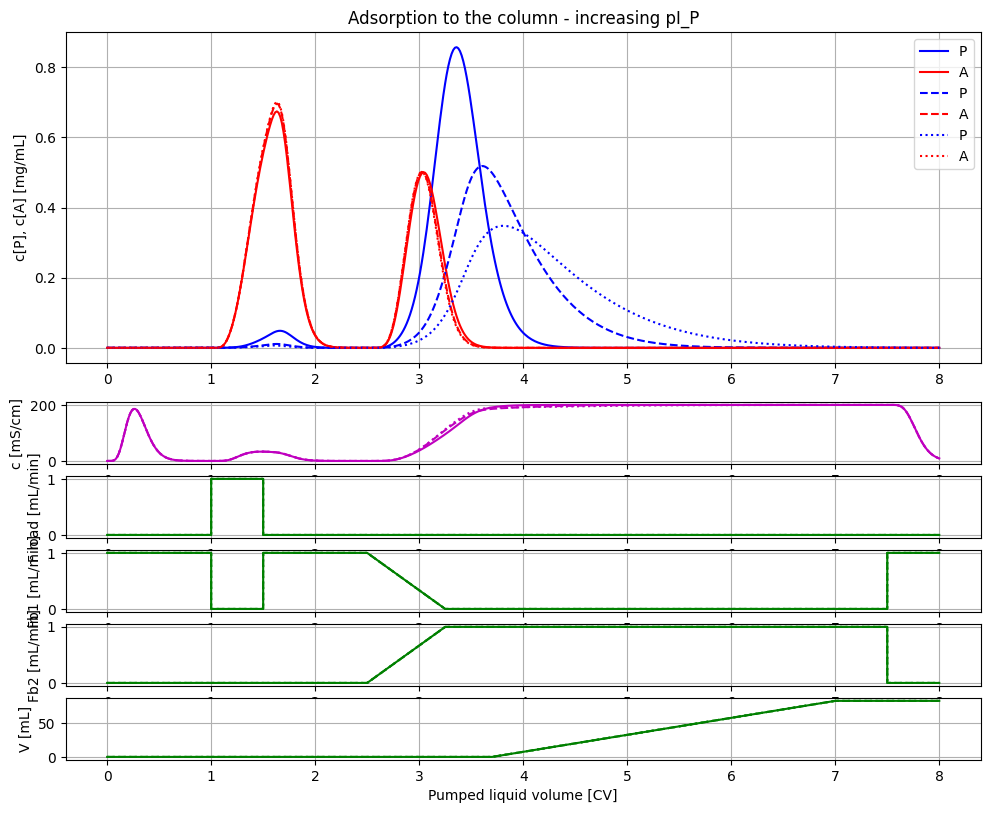

In [17]:
# Let us investigate the impact of change of the iso-electric pH for protein P

# Simulate and plot the results
newplot(title='Adsorption to the column - increasing pI_P', plotType='Elution-conductivity-vs-CV-combined-all')

for value in [7.2, 7.6, 8.0]:
    par_pH(pI_P=value, pI_A=7.1667, pH_resin=7.0)
    simu((CV_ekv+CV_ads+CV_wash+CV_desorb+CV_wash2)*V/VFR)

# Restore default values
par(k2 = 0.05, k4 = 0.3)

Note, with increasing pI_P the binding of P increase which leads less loss of product during adsorption. During desorption the peak height is lower with increasing binding strenght, but the total amoiunt of product P that can be harvested is higher, due to the smaller loss during adsorption.

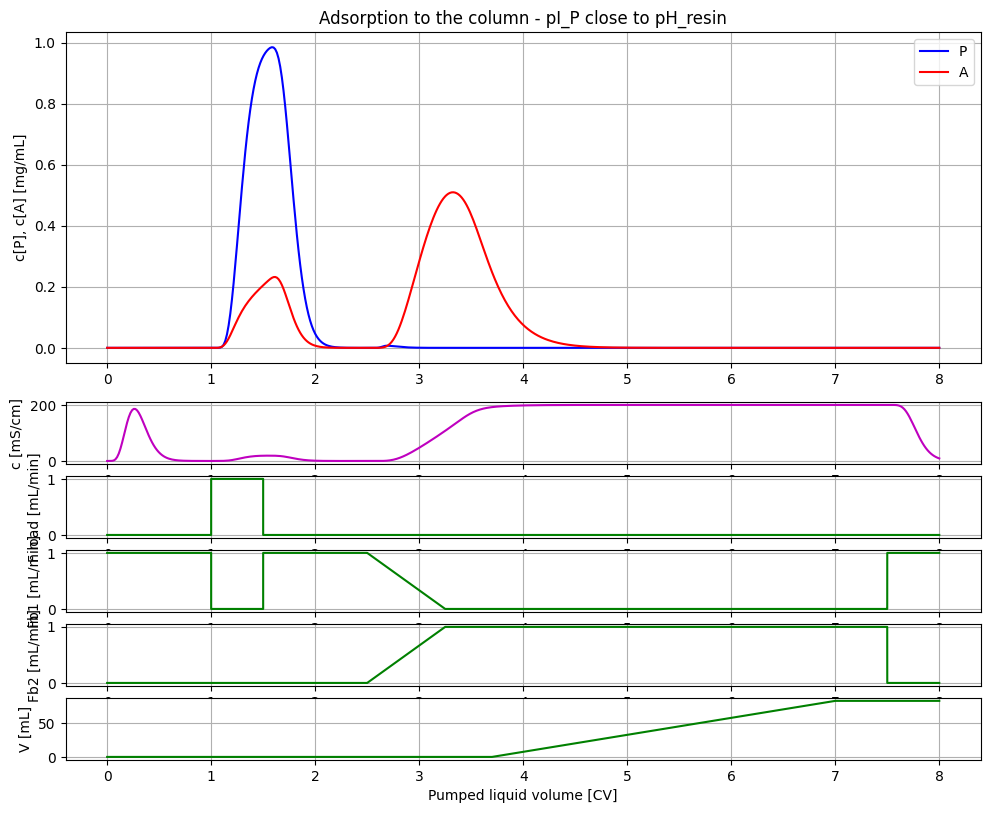

In [18]:
# Let us investigate the impact of pI_P close to pH_resin

# Simulate and plot the results
newplot(title='Adsorption to the column - pI_P close to pH_resin', plotType='Elution-conductivity-vs-CV-combined-all')

for value in [7.0001]:
    par_pH(pI_P=value, pI_A=8)
    simu((CV_ekv+CV_ads+CV_wash+CV_desorb+CV_wash2)*V/VFR)

# Restore default values
par(k2=0.05, k4=0.3)

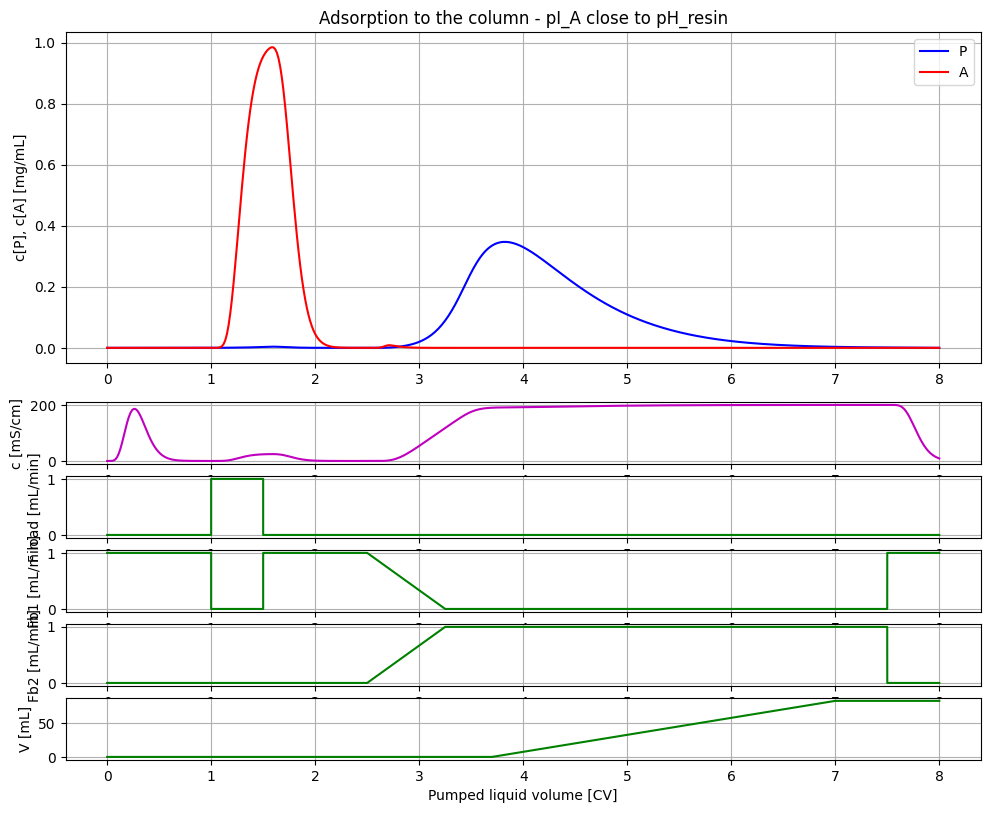

In [19]:
# Let us investigate the impact of pI_A close to pH_resin

# Simulate and plot the results
newplot(title='Adsorption to the column - pI_A close to pH_resin', plotType='Elution-conductivity-vs-CV-combined-all')

for value in [7.001]:
    par_pH(pI_P=8.0, pI_A=value)
    simu((CV_ekv+CV_ads+CV_wash+CV_desorb+CV_wash2)*V/VFR)

# Restore default values
par(k2=0.05, k4=0.3)

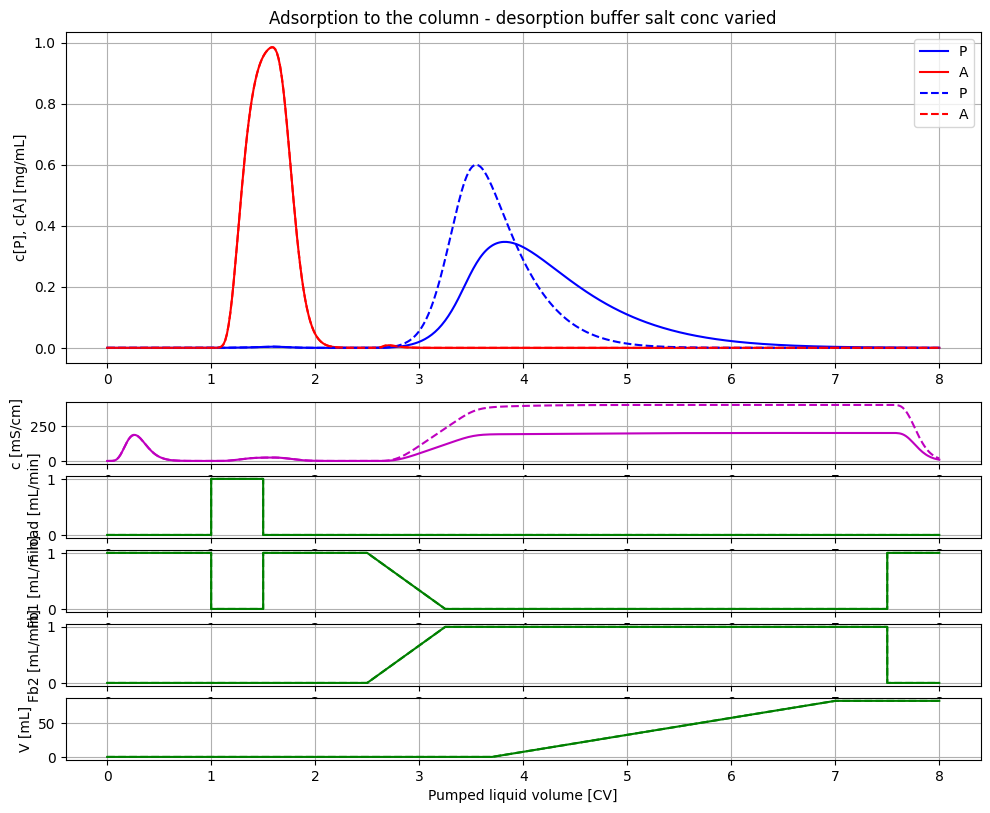

In [20]:
# Let us also investigate the impact of salt concentration of the desorptions buffer

# Simulate and plot the results
newplot(title='Adsorption to the column - desorption buffer salt conc varied', plotType='Elution-conductivity-vs-CV-combined-all')

for value in [8.0, 16.0]:
    par(E_in_desorption_buffer=value)
    par_pH(pI_P=8.0, pI_A=7.001, pH_resin=7.0)
    simu((CV_ekv+CV_ads+CV_wash+CV_desorb+CV_wash2)*V/VFR)

# Restore default values
par(E_in_desorption_buffer=8.0)
par(k2=0.05, k4=0.3)

## 5 Breakthrough curve often used during process development

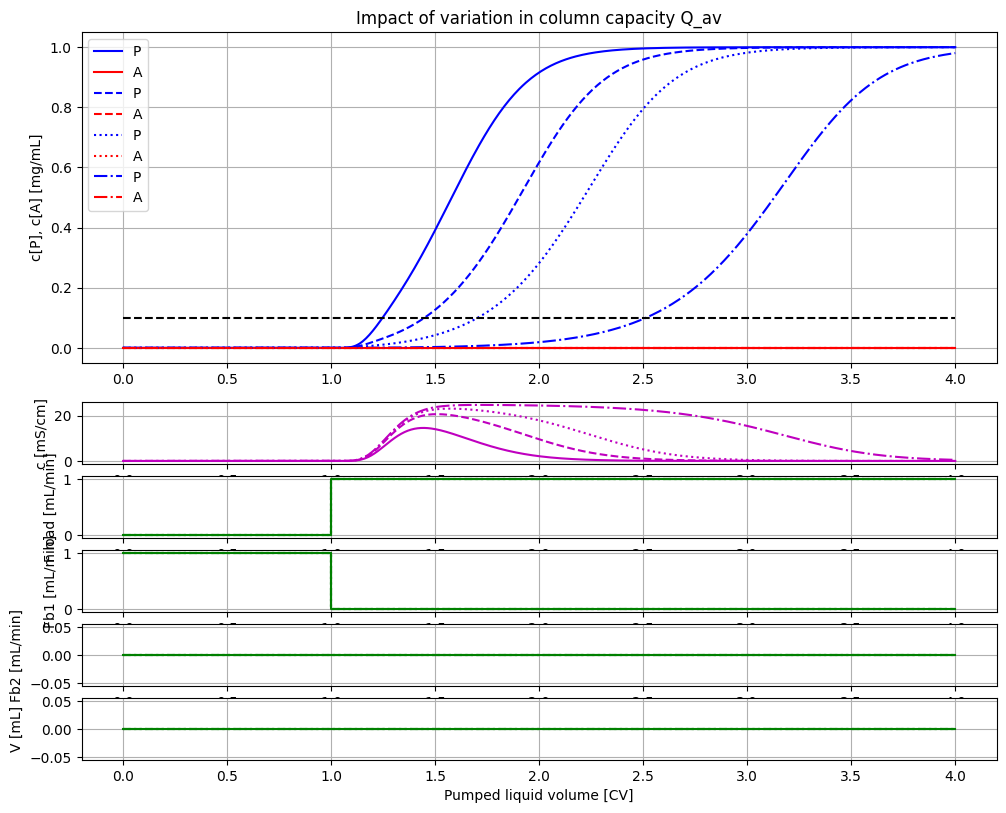

In [21]:
# Experiment to check column capacity Q_av often called breakthrough curve
par(P_in=1, A_in=0, E_in=0)
init(E_start = 0)
par(Q_av=6.0)

par(scale_volume=True, start_adsorption=1*V, stop_adsorption=4.01*V)
par(start_desorption=10*V, stationary_desorption=10.5*V, stop_desorption=11*V)
par(start_pooling=11*V, stop_pooling=12*V)

newplot(title='Impact of variation in column capacity Q_av', plotType='Elution-conductivity-vs-CV-combined-all')
for value in [1, 2, 3, 6]: par(Q_av=value); simu(4.0*V/VFR)

# Linje för 10% UV
ax1.plot([0,4], [0.1,0.1],'k--')

# Restore default parameters
par(Q_av=6.0, A_in=1.0)

With greater column capacity Q_av the longer it takes before the concentration of protein start to increase. Note, that the salt concenration increase initially during adsorption but then go back to low levels. This phenomenon ia also seen experimentally.

## 6 Summary
The simplified simulation model was found useful to describe operational aspects of ion exchange chromtography.
* The model describe qualitatively well the impact of typical operational changes in the flow rate.
* The model also describe qualtively well the impact of changes in iso-electric point of the proteins relative the pH of the resin.
* The small deviations in salt concentration from linear increase during the gradient in the salt buffer is also what you see in reality.


## References

1) Månsson, Jonas, "Control of chromatography comlumn in production scale", Master thesis TFRT-5599, Department of Automatic Control, LTH, Lund Sweden, 1998.
2) Pharmacia LKB Biotechnology. "Ion Exchange chromatography. Principles and Methods.", 3rd edition, 1991.

## Appendix

In [23]:
describe('MSL')

MSL: 3.2.3 - used components: RealInput, RealOutput, CombiTimeTable, Types


In [24]:
system_info()


System information
 -OS: Linux
 -Python: 3.11.11
 -Scipy: not installed in the notebook
 -FMPy: 0.3.20
 -FMU by: OpenModelica Compiler OpenModelica 1.25.0~dev-133-ga5470be
 -FMI: 2.0
 -Type: ME
 -Name: BPL_IEC.Column_system
 -Generated: 2024-11-07T15:02:05Z
 -MSL: 3.2.3
 -Description: Bioprocess Library version 2.3.0
 -Interaction: FMU-explore for FMPy version 1.0.1
